# Setup

In [1]:
!pip install timm torch torchvision opencv-python datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 48.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import cv2
from tqdm import tqdm
from datasets import load_dataset
from torchvision.models.segmentation import fcn_resnet50
import timm
from PIL import Image
import glob
from scipy.io import loadmat
from torch.utils.data import random_split, DataLoader, Dataset
import torch.optim as optim
import fnmatch
import matplotlib.pyplot as plt

## Data exploration

In [3]:
transform_city = T.Compose([
    T.Resize((256, 256)),
])

transform_nyu = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

### CityScapes

torch.Size([256, 256, 3])
torch.Size([256, 256, 1])


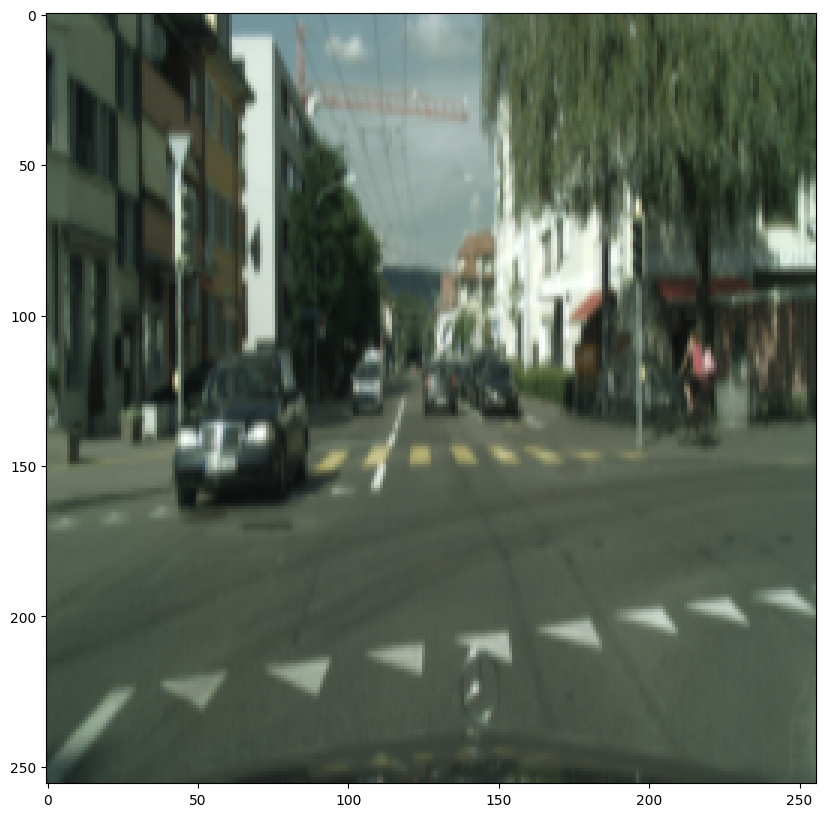

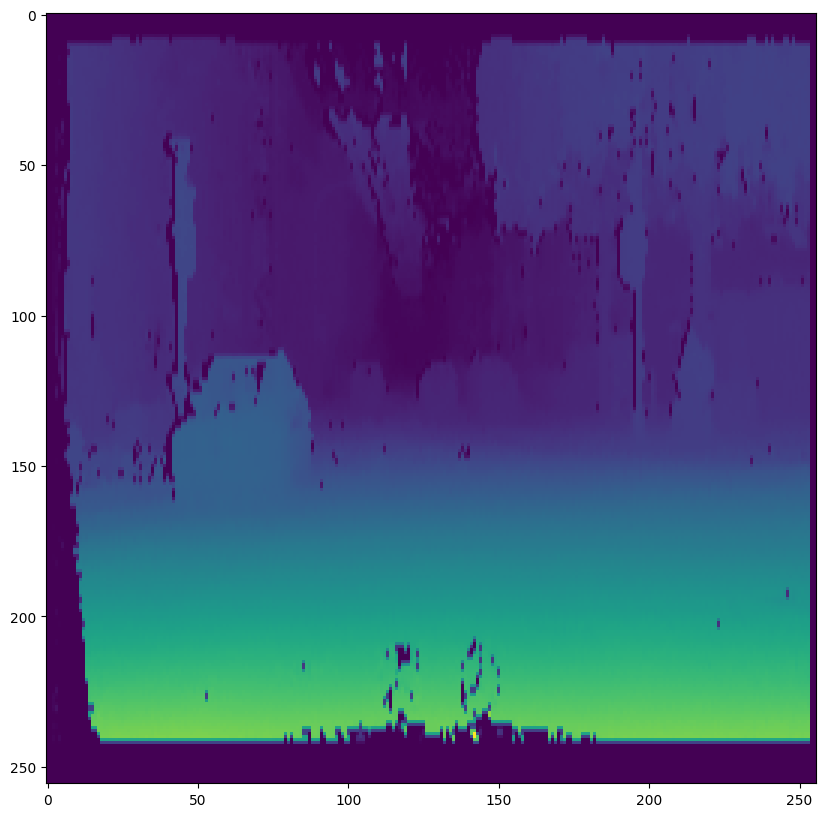

In [4]:
# Data exploration
image = torch.from_numpy(np.moveaxis(np.load('/content/drive/MyDrive/Capstone/CityScapes/data/train/image/{:d}.npy'.format(2974)), -1, 0))
image = transform_city(image)
image = np.transpose(image, (1, 2, 0))
print(image.shape)

depth = torch.from_numpy(np.moveaxis(np.load('/content/drive/MyDrive/Capstone/CityScapes/data/train/depth/{:d}.npy'.format(2974)), -1, 0))
depth = transform_city(depth)
depth = np.transpose(depth, (1, 2, 0))
print(depth.shape)

plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(depth)
plt.show()

### NYU Depth

torch.Size([256, 256, 3])
torch.Size([256, 256, 1])


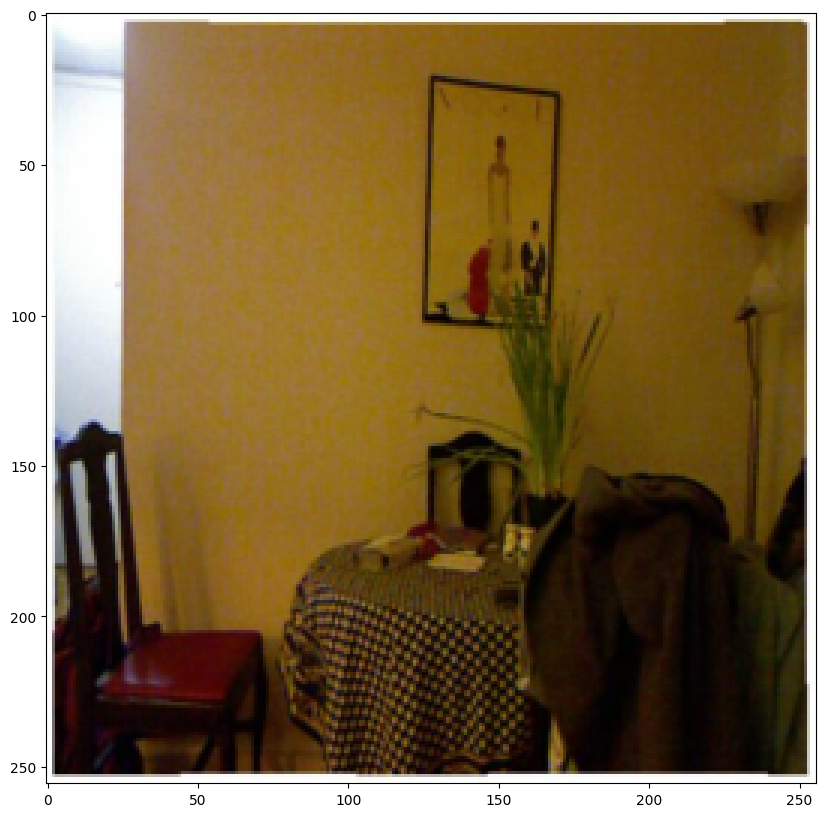

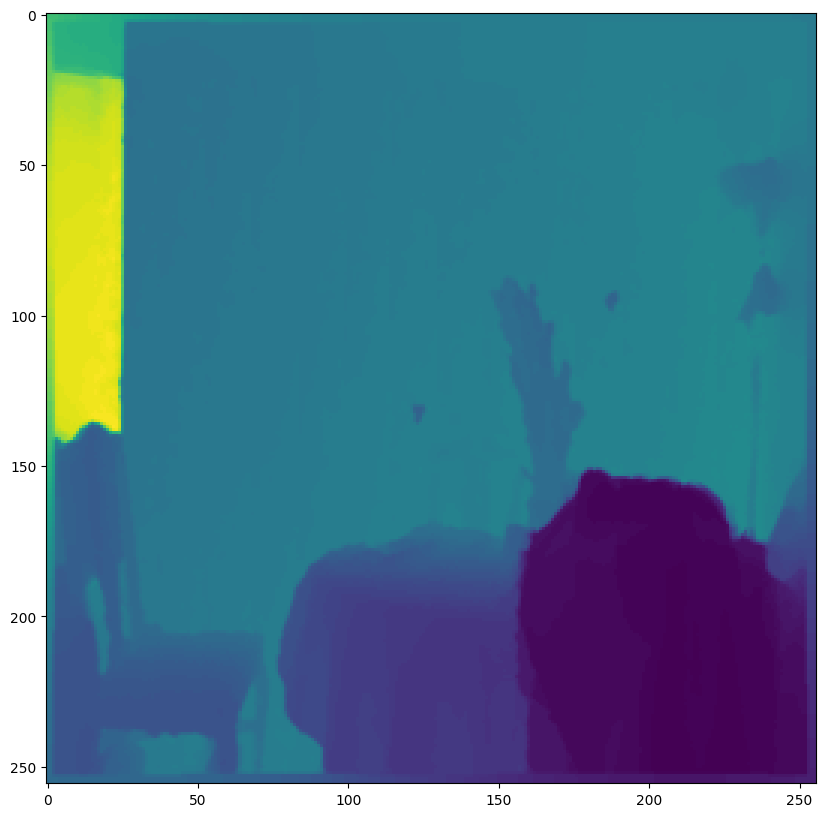

In [5]:
image = transform_nyu(Image.open("/content/drive/MyDrive/Capstone/NYU/data/living_room_0004_out/211.jpg").convert('RGB'))
image = np.transpose(image, (1, 2, 0))
print(image.shape)

depth_map = transform_nyu(Image.open("/content/drive/MyDrive/Capstone/NYU/data/living_room_0004_out/211.png").convert('L'))
depth_map = np.transpose(depth_map, (1, 2, 0))
print(depth_map.shape)

plt.figure(figsize = (10,10))
plt.imshow(image)
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(depth_map)
plt.show()

# Dataset and Models

## Datasets

In [6]:
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.depth_paths = []

        # Collect all image and depth map paths
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                for image_path in glob.glob(os.path.join(folder_path, '*.jpg')):
                    depth_path = image_path.replace('.jpg', '.png')
                    if os.path.exists(depth_path):
                        self.image_paths.append(image_path)
                        self.depth_paths.append(depth_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        depth_path = self.depth_paths[idx]

        image = Image.open(image_path).convert('RGB')
        depth_map = Image.open(depth_path).convert('L')

        if self.transform:
            image = self.transform(image)
            depth_map = self.transform(depth_map)

        image = np.transpose(image, (1, 2, 0))
        depth_map = np.transpose(depth_map, (1, 2, 0))

        return image, depth_map

In [7]:
class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))
        self.transform = transform

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))

        if self.transform:
            image = self.transform(image)
            depth = self.transform(depth)

        image = np.transpose(image, (1, 2, 0)).float()
        depth = np.transpose(depth, (1, 2, 0)).float()

        return image, depth

    def __len__(self):
        return self.data_len

## Models

In [8]:
# Baseline model for comparison
class DepthEstimationModel(nn.Module):
    def __init__(self):
        super(DepthEstimationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
class VITBasedModel(nn.Module):
    def __init__(self, vit_model_name='vit_base_patch16_224', img_size=256):
        super(VITBasedModel, self).__init__()
        self.vit = timm.create_model(vit_model_name, pretrained=True)

        self.vit.patch_embed = nn.Conv2d(3, 768, kernel_size=16, stride=16, padding=0)
        self.vit.patch_embed.num_patches = (img_size // 16) ** 2

        self.vit.head = nn.Identity()

        self.conv1 = nn.Conv2d(768, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.vit.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)  # B x num_patches x patch_dim
        x = self.vit.blocks(x)
        x = self.vit.norm(x)
        x = x.permute(0, 2, 1).contiguous().view(-1, 768, self.vit.patch_embed.num_patches // (256 // 16), 256 // 16)

        x = nn.functional.interpolate(x, scale_factor=16, mode='bilinear', align_corners=False)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        return x

In [10]:
class MiDASDepthEstimationModel(nn.Module):
    def __init__(self, model_name='DPT_Hybrid'):
        super(MiDASDepthEstimationModel, self).__init__()
        self.midas = torch.hub.load("intel-isl/MiDaS", model_name, pretrained=True)

        # Adjust the final layer for single-channel depth output
        self.midas.scratch.output_conv = nn.Conv2d(256, 1, kernel_size=1)

    def forward(self, x):
        if self.training:
            x = self.midas(x)
        else:
            with torch.no_grad():
                x = self.midas(x)

        if x.dim() == 3:
            x = x.unsqueeze(1)

        # Resize the output to match the ground truth dimensions (256x256)
        x = torch.nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x

# Training & Evaluation

## Dataloaders

In [11]:
def create_cityscapes_dataloaders():
  dataset_path = '/content/drive/MyDrive/Capstone/CityScapes/data'
  train_set = CityScapesDataset(root=dataset_path, transform=transform_city, train=True)
  test_set = CityScapesDataset(root=dataset_path, transform=transform_city, train=False)

  batch_size = 16
  train_loader = torch.utils.data.DataLoader(
      dataset=train_set,
      batch_size=batch_size,
      shuffle=True)

  test_loader = torch.utils.data.DataLoader(
      dataset=test_set,
      batch_size=batch_size,
      shuffle=False)

  return train_loader, test_loader

def create_nyu_dataloaders():
    dataset = NYUDepthDataset("/content/drive/MyDrive/Capstone/NYU/data/", transform_nyu)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [12]:
nyu_train_loader, nyu_test_loader = create_nyu_dataloaders()
city_train_loader, city_test_loader = create_cityscapes_dataloaders()

## Training Pipeline

In [13]:
def train_model(model, train_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, depths in tqdm(train_loader):
            images, depths = images.to(device), depths.to(device)
            optimizer.zero_grad()
            outputs = model(images.permute(0, 3, 1, 2).float())
            loss = criterion(outputs, depths.permute(0, 3, 1, 2).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return model

## Evaluation Pipeline

In [14]:
def compute_metrics(predicted, ground_truth):
    abs_diff = torch.abs(predicted - ground_truth)
    mae = torch.mean(abs_diff)
    rmse = torch.sqrt(torch.mean(abs_diff ** 2))

    max_ratio = torch.max(predicted / ground_truth, ground_truth / predicted)
    delta_1 = torch.mean((max_ratio < 1.25).float())
    delta_2 = torch.mean((max_ratio < 1.25 ** 2).float())
    delta_3 = torch.mean((max_ratio < 1.25 ** 3).float())

    return mae, rmse, delta_1, delta_2, delta_3

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device).eval()

    mae_list, rmse_list, delta_1_list, delta_2_list, delta_3_list = [], [], [], [], []
    with torch.no_grad():
        for images, depths in test_loader:  # Use a validation dataloader if available
            images, depths = images.to(device), depths.to(device)
            outputs = model(images.permute(0, 3, 1, 2).float())
            mae, rmse, delta_1, delta_2, delta_3 = compute_metrics(outputs, depths.permute(0, 3, 1, 2).float())

            mae_list.append(mae.item())
            rmse_list.append(rmse.item())
            delta_1_list.append(delta_1.item())
            delta_2_list.append(delta_2.item())
            delta_3_list.append(delta_3.item())

    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_delta_1 = np.mean(delta_1_list)
    mean_delta_2 = np.mean(delta_2_list)
    mean_delta_3 = np.mean(delta_3_list)

    return mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3

# Experiments and Results

## NYU Depth

In [15]:
simple_model = DepthEstimationModel()
vit_model = VITBasedModel()
midas_model = MiDASDepthEstimationModel()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [16]:
print("Training simple depth model on NYU Depth V2 dataset")
simple_model = train_model(simple_model, nyu_train_loader, num_epochs=2, lr=1e-4)

model_save_path = '/content/simple_nyu_model.pth'
torch.save(simple_model.state_dict(), model_save_path)

Training simple depth model on NYU Depth V2 dataset


100%|██████████| 263/263 [1:44:13<00:00, 23.78s/it]


Epoch 1/2, Loss: 0.0382


100%|██████████| 263/263 [01:18<00:00,  3.36it/s]

Epoch 2/2, Loss: 0.0303


In [17]:
print("Training VIT-based depth model on NYU Depth V2 dataset")
vit_model = train_model(vit_model, nyu_train_loader, num_epochs=2, lr=1e-4)

model_save_path = '/content/vit_nyu_model.pth'
torch.save(vit_model.state_dict(), model_save_path)

Training VIT-based depth model on NYU Depth V2 dataset


  0%|          | 0/263 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 11.30 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 1/263 [00:02<12:00,  2.75s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to alloca

Epoch 1/2, Loss: 0.3127


100%|██████████| 263/263 [09:45<00:00,  2.22s/it]


Epoch 2/2, Loss: 0.0327


In [18]:
# Fine-tune pre-trained models
print("Fine-tuning MiDaS on NYU Depth V2 dataset")
midas_model = train_model(midas_model, nyu_train_loader, num_epochs=2, lr=1e-5)

model_save_path = '/content/midas_nyu_model.pth'
torch.save(midas_model.state_dict(), model_save_path)

Fine-tuning MiDaS on NYU Depth V2 dataset


100%|██████████| 263/263 [03:14<00:00,  1.36it/s]


Epoch 1/2, Loss: 0.3012


100%|██████████| 263/263 [03:12<00:00,  1.37it/s]


Epoch 2/2, Loss: 0.0451


In [19]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(simple_model, nyu_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.1345979215746576
0.17267057818896842
0.3257442631504752
0.5872575351686189
0.7700188430872831


In [20]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(vit_model, nyu_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.1622009426355362
0.19175916255423517
0.25819220235853485
0.4937951691222913
0.7024404018214254


In [21]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(midas_model, nyu_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.14161209762096405
0.1823685017950607
0.3740298097783869
0.6166408188415297
0.7741599570621144


## CityScapes

In [15]:
simple_model = DepthEstimationModel()
vit_model = VITBasedModel()
midas_model = MiDASDepthEstimationModel()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Downloading: "https://github.com/isl-org/MiDa

In [16]:
print("Training simple depth model on CityScapes dataset")
simple_model = train_model(simple_model, city_train_loader, num_epochs=2, lr=1e-4)

model_save_path = '/content/simple_city_model.pth'
torch.save(simple_model.state_dict(), model_save_path)

Training simple depth model on CityScapes dataset


100%|██████████| 186/186 [1:08:01<00:00, 21.94s/it]


Epoch 1/2, Loss: 0.0113


100%|██████████| 186/186 [00:26<00:00,  7.02it/s]

Epoch 2/2, Loss: 0.0083


In [17]:
print("Training VIT-based depth model on CityScapes dataset")
vit_model = train_model(vit_model, city_train_loader, num_epochs=2, lr=1e-4)

model_save_path = '/content/vit_city_model.pth'
torch.save(vit_model.state_dict(), model_save_path)

Training VIT-based depth model on CityScapes dataset


100%|██████████| 186/186 [02:36<00:00,  1.19it/s]


Epoch 1/2, Loss: 0.5064


100%|██████████| 186/186 [02:36<00:00,  1.19it/s]


Epoch 2/2, Loss: 0.0109


In [18]:
# Fine-tune pre-trained models
print("Fine-tuning MiDaS on CityScapes dataset")
midas_model = train_model(midas_model, city_train_loader, num_epochs=2, lr=1e-5)

model_save_path = '/content/midas_city_model.pth'
torch.save(midas_model.state_dict(), model_save_path)

Fine-tuning MiDaS on CityScapes dataset


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


Epoch 1/2, Loss: 0.2514


100%|██████████| 186/186 [01:02<00:00,  2.98it/s]


Epoch 2/2, Loss: 0.0427


In [19]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(simple_model, city_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.06863046274520457
0.09035045746713877
0.19236212968826294
0.3713078200817108
0.5360063016414642


In [20]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(vit_model, city_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.09146241145208478
0.1062616768758744
0.1396617293357849
0.2805824279785156
0.43175166845321655


In [21]:
mean_mae, mean_rmse, mean_delta_1, mean_delta_2, mean_delta_3 = evaluate(midas_model, city_test_loader)
print(mean_mae)
print(mean_rmse)
print(mean_delta_1)
print(mean_delta_2)
print(mean_delta_3)

0.1363305663689971
0.17583732958883047
0.37778860330581665
0.49333158135414124
0.5804930925369263
